In [1]:
#importing necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm

In [2]:
#building the environment
class Environment:
    def __init__(self, M,N, holes, terminal_state): #initializing the environment states, holes, terminals and rewards
        self.states = set()
        self.shape = (M,N)
        self.holes = holes
        self.terminal_state = terminal_state
        
        for i in range(1,M+1):
            for j in range(1, N+1):
                if (i,j) not in holes:
                    self.states.add((i,j))
                    
        self.rewards = self.initialize_rewards()
        self.prob_agent_action = [0.8, 0.1, 0.05, 0.05]
    def initialize_rewards(self): #function to initialize the rewards for each state of the environment
        r = {}
        for state in self.states:
            if state == (6,3):
                r[state] = -15
            elif state == (6,6):
                r[state] = 15
            else:
                r[state] = 0
                
        return r
    
    def agent_move(self, s, a): #function to update the state of the agent given an action a and current state s
        x, y = s
        if a=='U':
            x = x-1
        elif a=='D':
            x = x + 1
        elif a=='R':
            y = y + 1
        elif a=='L':
            y = y - 1
            
        stay_same = self.check_corner_and_hole((x,y))

        if stay_same:
            return s

        return (x,y)

    def move_clockwise90(self, a): #function to return the action which is a 90 degree rotation to current action a
        if a=='U':
            return 'R'
        elif a=='R':
            return 'D'
        elif a=='D':
            return 'L'
        elif a=='L':
            return 'U'
        
    def move_anti_clockwise90(self, a): #function to return the action which is a 90 degree rotation to current action a
        if a=='U':
            return 'L'
        elif a=='L':
            return 'D'
        elif a=='D':
            return 'R'
        elif a=='R':
            return 'U'
    
    def check_corner_and_hole(self, s): 
        #function to check if the updates state goes out of the gridworld or goes into holes. 
        #If so, it returns a True value to address that the update should not take place and agent should remain in current state. 
        x1, y1 = s
        stay_same = False
        for hole in self.holes:
            if (x1,y1) == hole:
                stay_same = True

        if x1<1 or x1>6:
            stay_same = True
        if y1<1 or y1>6:
            stay_same = True
        
        return stay_same
    
    
            

In [3]:
gridworld = Environment(6,6, [(4,3),(5,3)], (6,6))


In [8]:
#building the agent
class Agent:
    def __init__(self, gamma, env, terminal_state_value = 0):
        #initializing the agent parameters
        self.actions = ['L','R','U','D'] #possible actions
        self.gamma = gamma #discount parameter
        self.terminal_state_value = terminal_state_value
        self.pi = self.initialize_policy(env)
        self.V = self.initialize_value_states(env)
        self.Q = self.initialize_Qvalue(env)
        
        
    def initialize_policy(self,env):
        #initializing the agent policy
        pi = {}
        for s in env.states:
            pi[s] = {}
            for a in self.actions:
                pi[s][a] = 0.25
                
        return pi
            
    def initialize_Qvalue(self, env):
        #initializing q values for the agent
        Q = {}
        for s in env.states:
            Q[s] = {}
            for a in self.actions:
                Q[s][a] = 0
                
        return Q
    
    def initialize_value_states(self, env):
        #initializing value of states 
        v_s = {}
        for state in env.states:
            if state == env.terminal_state: 
                #0 for part 1.a, 15 for for part 1.b) 
                v_s[state] = self.terminal_state_value        
            else:
                v_s[state] = random.random()
        return v_s
                
    def compute_value(self, env, epsilon = 1e-8):
        #function for policy evaluation to compute value of states and state-action pair Q values
        delta = np.inf
        
        while delta > epsilon:
            max_diff = -np.inf
            for s in env.states:
                if s!=env.terminal_state:
                    v = 0
                    for a in self.pi[s]:
                        p = self.pi[s][a]
                        #with prob 0.8 take action a to get to state s1 with reward r1
                        s1 = env.agent_move(s,a)
                        r1 = env.rewards[s1]

                        v1 = 0.8 * (r1 + self.gamma*self.V[s1])

                        #with prob 0.1 stay in same state s
                        r2 = env.rewards[s]
                        v2 = 0.1 * (r2 + self.gamma * self.V[s])

                        #with prob 0.05 take action in direction +90 degree clockwise direction
                        a3 = env.move_clockwise90(a)
                        s3 = env.agent_move(s, a3)
                        r3 = env.rewards[s3]
                        v3 = 0.05 * (r3 + self.gamma * self.V[s3])

                        #with prob 0.05 take action in direction -90 degree clockwise direction

                        a4 = env.move_anti_clockwise90(a)
                        s4 = env.agent_move(s, a4)
                        r4 = env.rewards[s4]
                        v4 = 0.05 * (r4 + self.gamma * self.V[s4])

                        v = v + (p * (v1+v2+v3+v4))
                        self.Q[s][a] = (v1 + v2 + v3 + v4)

                    diff = abs(self.V[s] - v)
                    self.V[s] = v
                    max_diff = max(max_diff, diff)
                
            delta = max_diff
            
    def policy_improve(self, env):
        #function for policy improvement where the policy is improved greedily
        
        for s in env.states:
            if s!=env.terminal_state:
                greedy_actions = []
                max_q = -np.inf

                for a in self.pi[s]:
                    #if self.pi[s][a]>0:
                    s1 = env.agent_move(s,a)
                    r1 = env.rewards[s1]

                    v1 = 0.8 * (r1 + self.gamma*self.V[s1])

                    #with prob 0.1 stay in same state s
                    r2 = env.rewards[s]
                    v2 = 0.1 * (r2 + self.gamma * self.V[s])

                    #with prob 0.05 take action in direction +90 degree clockwise direction
                    a3 = env.move_clockwise90(a)
                    s3 = env.agent_move(s, a3)
                    r3 = env.rewards[s3]
                    v3 = 0.05 * (r3 + self.gamma * self.V[s3])

                    #with prob 0.05 take action in direction -90 degree clockwise direction

                    a4 = env.move_anti_clockwise90(a)
                    s4 = env.agent_move(s, a4)
                    r4 = env.rewards[s4]
                    v4 = 0.05 * (r4 + self.gamma * self.V[s4])

                    v = (v1 + v2 + v3 + v4)

                    if v > max_q:
                        greedy_actions = [a]
                        max_q = v
                    elif v == max_q:
                        greedy_actions.append(a)

                #update policy greedily
                n = len(greedy_actions)
                for a in self.pi[s]:
                    if a in greedy_actions:
                        self.pi[s][a] = 1.0/n
                    else:
                        self.pi[s][a] = 0
    
        
    def policy_iterate(self, env, iterations = 100):
        #function for policy iteration
        v_11_across_ep = []
        for iteration_number in range(iterations):
            self.compute_value(env)
            v_11_across_ep.append(self.V[(1,1)])
            self.policy_improve(env)
        
        return v_11_across_ep
         
    def find_optimal_move(self, s):
        #function to find the optimal move at a given state s
        optimal_moves = []
        max_v = 0
        for a in self.pi[s]:
            if self.pi[s][a] > max_v:
                optimal_moves = [a]
                max_v = self.pi[s][a]
            elif self.pi[s][a] == max_v:
                optimal_moves.append(a)
                
        return optimal_moves
    
            
    def plot_state_and_policy(self, env, plot_state_values = False, label = None):
        #function to plot state values and policy
        plt.figure(figsize = (20, 10))
        Grid_plot=plt.subplot()
        M,N = env.shape
        for i in range(M):
            for j in range(N):
                s = (i+1, j+1)
                if s==env.terminal_state:
                    if plot_state_values:
                        t = round(self.V[s], 3)
                        value = str(s) + "\n\n" + "TERMINAL"
                    else:
                        value = "TERMINAL"
                elif s not in env.holes:
                    value=str(s)
                    move = self.find_optimal_move(s)
                    if plot_state_values==False:
                        value = value + '\n\n' + ','.join(move)
                    else:
                        t = round(self.V[s],3)
                        value = value + '\n\n' + str(t)
                else:
                    value = "HOLE"
                
                
                
                Grid_plot.text(j+0.5,N-i-0.5,value,ha='center',va='center')
        
        Grid_plot.grid(color='k')
        Grid_plot.axis('scaled')
        Grid_plot.axis([0, M, 0, N])
        
        Grid_plot.set_yticklabels([])
        Grid_plot.set_xticklabels([])
        if label is not None:
            plt.savefig(label)        
            
        
            

### 1.a) 

#### i) Value of states for random policy of taking each action with probability 0.25

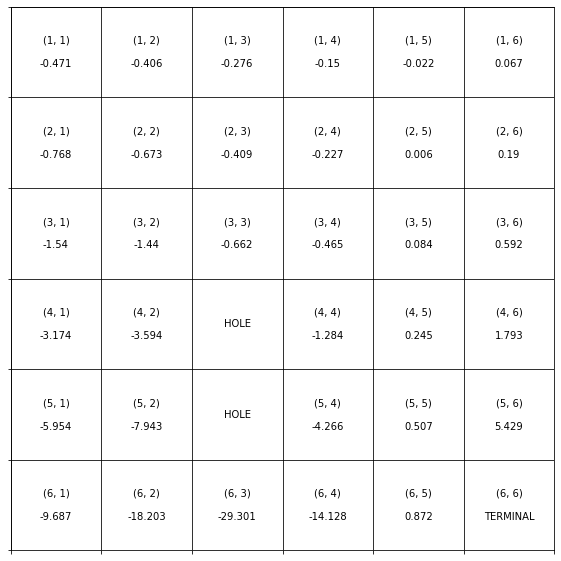

In [9]:
agent = Agent(0.9, gridworld)
agent.compute_value(gridworld)
agent.plot_state_and_policy(gridworld, plot_state_values = True,label = 'plots/1_a.png')

In [10]:
def plot_q_values(agent, env, label = None):
    plt.figure(figsize = (20, 10))
    Grid_plot=plt.subplot()
    M,N = env.shape
    for i in range(M):
        for j in range(N):
            s = (i+1, j+1)
            if s==env.terminal_state:
                value = str(s) + "\n\n" + "TERMINAL"
            elif s not in env.holes:
                value=str(s)
                qs = {}
                for a in agent.actions:
                    qs[a] = round(agent.Q[s][a],3)

                value = value + "\n\n" + "L :  {}\nR :  {}\nU :  {}\nD :  {}".format(qs['L'],qs['R'],qs['U'],qs['D'])
            else:
                value = "HOLE"



            Grid_plot.text(j+0.5,N-i-0.5,value,ha='center',va='center')

    Grid_plot.grid(color='k')
    Grid_plot.axis('scaled')
    Grid_plot.axis([0, M, 0, N])

    Grid_plot.set_yticklabels([])
    Grid_plot.set_xticklabels([])
    if label is not None:
        plt.savefig(label)     
    

#### ii) Q-Values of each state action pair for the random policy of choosing each action with probability 0.25

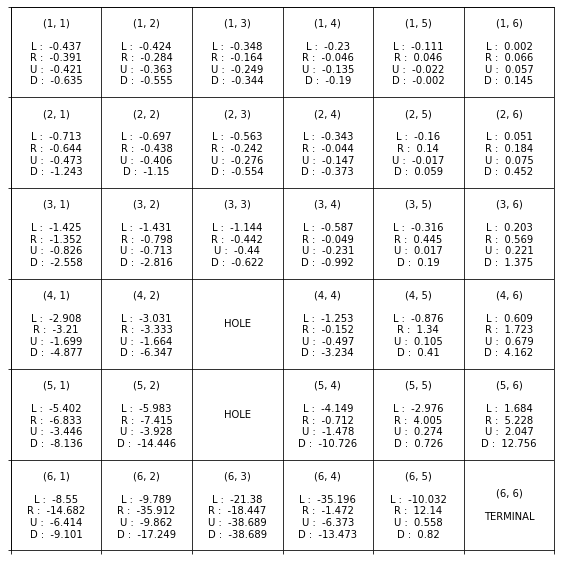

In [11]:
plot_q_values(agent, gridworld, label = "plots/1_a_q_values.png")

### 1.b) Policy Iteration

In [12]:
agent = Agent(0.9, gridworld, terminal_state_value = 15)
values = agent.policy_iterate(gridworld)


Plot of values of state (1,1) across iterations

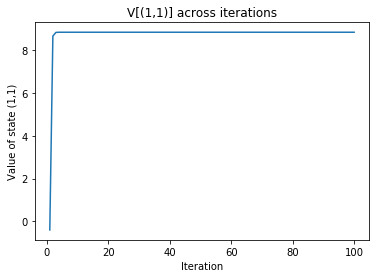

In [13]:
def plot_values(values,label = None):
        ts = np.arange(1,(len(values)+1))
        plt.plot(ts, values)
        plt.xlabel("Iteration")
        plt.ylabel("Value of state (1,1)")
        plt.title("V[(1,1)] across iterations")
        if label is not None:
            plt.savefig(label)
        plt.show()
        
plot_values(values, label = 'plots/1_b_value_state_across_iterations.png')

Plot of optimal policy for each state 

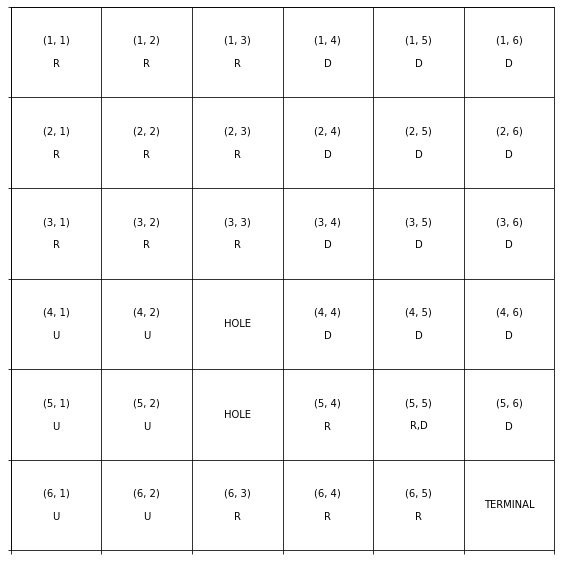

In [14]:
agent.plot_state_and_policy(gridworld, label = 'plots/1_b_opt_policy.png')